<a href="https://colab.research.google.com/github/whtan88/RandomDataAnalyst_Projects/blob/main/MountainCar_Q_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MountainCar Q-Learning**

Hi everyone, this is my first foray into Reinforcement Learning. This is my first set of code for Reinforcement Learning, specifically using Q-learning. The environment that I have chosen is from OpenAI Gymnasium MountainCar-v0.

It is a simple environment which involves a car starting off at the valley floor, with the objective of getting to the right top of the valley.

The goal is to try and train an algorithm to succeed in the above stated objective and we will experiment with different variants or inputs to see the various results of it.

I used the below websites for references on the OpenAI Gymnasium MountainCar Environment. Thanks to Sentdex and Jeff Heaton for starting me off on coding for Q learning.

I have also created a YouTube Video to explain my workings. It would contain more information than the notes here. You may find the link to it here.

---


References:
<br>OpenAi Gynmasium MountainCar documentation: https://gymnasium.farama.org/environments/classic_control/mountain_car/

MountainCar environment details: https://github.com/openai/gym/wiki/MountainCar-v0

Sentdex Q learning Python tutorial: https://pythonprogramming.net/q-learning-reinforcement-learning-python-tutorial/#google_vignette

Introduction to the OpenAI Gym by Jeff Heaton:
https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_12_01_ai_gym.ipynb#scrollTo=cciTuR2MIeX-


We begin by installing the necessary libraries to start us off on this. As I am doing this on Google Colab, there are some issues with displaying results on the Notebook interface and hence there is a need to install multiple libraries below. Some of them are redundant, such as the Atari installations but it is good to keep them here for reference as you will need them to display the Atari Game environments available on OpenAI Gymnasium as well.

In [1]:
# Installation Codes required to render OpenAI Gym Environments
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

# Display of Atari Game
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

!apt install ffmpeg
!apt install xvfb
!pip install PyVirtualDisplay==3.0
!pip install gymnasium
!pip install swig
!pip install gymnasium[box2d]


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 9.7 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 41 not upgraded.
Need to get 7,814 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 

After installation, it is time to load the libraries below. I have included a utility function as well to have a summary view of the environment.

Note, after installing and loading the libraries, if there are error messages that prevent you from proceeding further, copy, paste and run the codes in a new notebook. Refreshing and restarting the same notebook might not work. Rerunning the codes in a new notebook works for me.

In [2]:
# define the functions used to show the video
import gymnasium as gym
# from gym.wrappers.record_video import RecordVideo
from gymnasium.wrappers.record_video import RecordVideo
import glob
import io
import base64
from base64 import b64encode
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
import uuid
import os
from os import listdir
# save file
from google.colab import drive
drive.mount('/content/drive')

# For static display of environment
import PIL.Image
import pyvirtualdisplay

# For visualisation
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


display = Display(visible=0, size=(1400, 1400))
display.start()

"""
Utility function to view attributes of the environment
"""

def query_environment(name):
    env = gym.make(name)
    spec = gym.spec(name)
    print(f"Action Space: {env.action_space}")
    print(f"Observation Space: {env.observation_space}")
    print(f"Goal Position: {env.unwrapped.goal_position}")
    print(f"Max Episode Steps: {spec.max_episode_steps}")
    print(f"Nondeterministic: {spec.nondeterministic}")
    print(f"Reward Range: {env.reward_range}")
    print(f"Reward Threshold: {spec.reward_threshold}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Overview of MountainCar-v0 Environment**

The goal is to reach the flag placed on top of the right hill as quickly as possible, with a penalty to the agent of reward of -1 for each timestep. There is no reward for the agent reaching the flag.

The starting position of the car is assigned a uniform random value in [-0.6 , -0.4]. The starting velocity of the car is always assigned to 0.

The episode ends if either of the following happens:
  1. Termination: The position of the car is greater than or equal to 0.5 (the goal position on top of the right hill)
  2. Truncation: The length of the episode is 200.

After the libraries are loaded, we will run a simple function to check the features of the environment.

---

<br> There are 3 discrete action spaces, and the actions that you can perform are:
  <br>  0: Accelerate to the left,
  <br>  1: Do nothing and
  <br>  2: Accelerate to the right.
<br> The Observation Space is an array with shape (2,), with the elements as follows: 0 - position of the car along the x-axis (min value = -1.2 & max value = 0.6), 1 - velocity of the car (min value = -0.07 & max value = 0.07)
<br> Goal Position is the position on the x-axis where the end goal is. In this case, it is 0.5. So you may notice that it is lesser than th emax value of the position from the Observation Space, 0.6, and you are right! The goal position is not the end of the x-axis. You will see it in subsequent lines of codes.
<br> Max Episode Steps is 200, which is the length of the episode, after 200 actions have been taken, the episode will be truncated and end prematurely if the car has not reached the goal position.
<br> Nondeterministic: Boolean to indicate if the observation of an environment cannot be repeated with the same initial state, random number generator state and actions. In this case, since it is false, it should mean that for the same seed, the state and actions are repeatable.
<br> Reward Range having no boundaries means that there are no limits to how we can adjust the rewards of the environment.
<br> Reward Threshold is the passing mark where the agent is considered to successfully complete the environment. The max steps is 200, which means the worst score is -200, and for an agent to be successful, it must at least have a score of >= -110, which means to be able to reach the objective in <=110 steps. Apart from this, completing this just once is not sufficient, and it must be repeatable for at least 100 times. This is a difficult threshold to beat.

Not to worry if the above doesn't make much sense at the moment. We will visualise it subsequently and hopefully, everything will start to make sense soon. Just keep the above parameters at the back of your mind.

In [ ]:
query_environment("MountainCar-v0")

Action Space: Discrete(3)
Observation Space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Goal Position: 0.5
Max Episode Steps: 200
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: -110.0


We can render a static image to get a sense of the environment below. Hopefully this will help in visualising and better understanding the parameters above. The car is at the valley floor, and the end goal is the yellow flag at the top right of the mountain valley. I have set a seed in the environment reset so that the starting position of the car is constant for each episode. Recall that if there is no seed provided, the starting position of the car is assigned a uniform random value in [-0.6, -0.4].

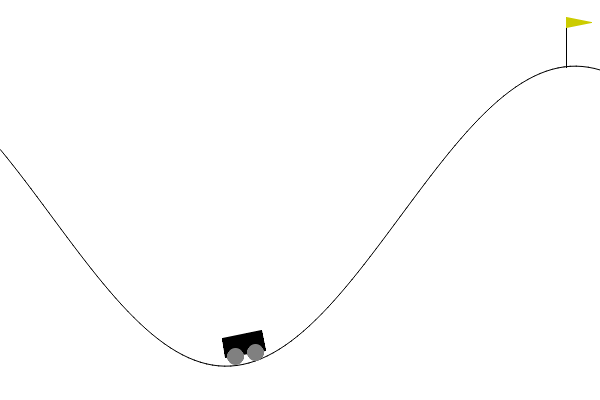

In [ ]:
env = gym.make("MountainCar-v0", render_mode = 'rgb_array')
observation1, info = env.reset(seed=123)

display = pyvirtualdisplay.Display(visible=0, size=(1400,1400)).start()
PIL.Image.fromarray(env.render())

Below are some additional helper functions to record vidoes of steps during each episode, and also to display the video in Google Colab.

RecordVideo is a wrapper function from gymnasium library to record videos of episodes and you can specify the input parameters accordingly. You may refer to the official library documentation for more information.

In [3]:
# Helper functions to create recording and show videos
def wrap_env(env, folder_name):
  env = RecordVideo(env, folder_name, step_trigger = lambda episode_number: True, video_length = 200, disable_logger = True)
  return env

def create_environment(name):
    folder_name = f"./video/{name}/{uuid.uuid4()}"
    #folder_name = "./content/drive/My Drive/Saved Files/"
    env = wrap_env(gym.make(name, render_mode="rgb_array"), folder_name)
    return env, folder_name

def show_video(folder_name):
  mp4list = glob.glob(f'{folder_name}/*.mp4')
  if os.path.isdir(folder_name):
    files = list(filter(os.path.isfile, mp4list))
    files.sort(key=lambda x: os.path.getmtime(x))
    mp4 = mp4list[-1]
    video = io.open(mp4, 'r+b').read()
    video_url = f"data:video/mp4;base64,{b64encode(video).decode()}"
    return HTML(f"""<video width={800} controls><source src="{video_url}"></video>""")
  else:
    print("Could not find video")

Things are starting to get more interesting. We will now record and run an episode of 200 actions / steps to get an idea of how it is like in an episode.

In [ ]:
# Dispay a sample of the starting environment
env, folder_name = create_environment("MountainCar-v0")
observation, _ = env.reset(seed=123)

for _ in range(200):
    action = env.action_space.sample()  # agent policy that uses the observation and info
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        observation, info = env.reset(seed=123)

env.close()
print(folder_name)
vid = list(filter(os.path.isfile, glob.glob(f'{folder_name}/*.mp4')))[0]
video = io.open(vid, 'r+b').read()
video_url = f"data:video/mp4;base64,{b64encode(video).decode()}"
HTML(f"""<video width={800} controls><source src="{video_url}"></video>""")

./video/MountainCar-v0/3b27dbba-ed4e-4194-9933-8bd75c1e1858


As expected, it did not perform very well, and the car did not go very far. Hopefully after implementing Q-Learning training, the car will be able to reach the objective.

---

For demonstration purposes, I will showcase another wrapper function, which is the RecordEpisodeStatistics. This will record some statistics done in each episode and will be returned as info output. If this function is not used, info will result in a null output. So the outputs of the recordings are:
<br>r = reward
<br>l = length of episodes
<br>t = time

From the results below, you can see the results being output as a dictionary.

This is more of an FYI as I will not be using this wrapper during my tests. Instead, I will be appending the output results into an array instead.

In [ ]:
# Show a sample of the info component using the RecordEpisodeStatistics function
env = gym.make("MountainCar-v0", render_mode = 'rgb_array')
env = gym.wrappers.RecordEpisodeStatistics(env=env)
observation1, info = env.reset(seed=123)

for _ in range(200):
    action = env.action_space.sample()  # agent policy that uses the observation and info
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
      print(info)
      observation, info = env.reset(seed=123)

env.close()


{'episode': {'r': array([-200.], dtype=float32), 'l': array([200], dtype=int32), 't': array([0.013519], dtype=float32)}}


# **Magic Happens here**

Here is where the magic happens. We will be defining all the functions that are necessary to perform Q-Learning here.

We will set a seed number, to keep the environment deterministic, and initialise a random uniform q table to store the q table results.

We will reintroduce the RecordVideo wrapper function, this time specifying a lambda function to record the video only on the last episode. This will hopefully help to reduce the runtime of the tests.

We will define the run_test function, and set predefined parameters for learning rate, discount, epsilon (for randomness), etc.

We will also save some stats during the episode runs, and define and monitor the performance of it.

In [4]:
# Specifying the seed so that the results are repeatable and kept somewhat constant
np.random.seed(888)

# Defining the q table here
env = gym.make("MountainCar-v0", render_mode = 'rgb_array')
os_dim = 20
q_table = np.random.uniform(low=-2, high=0, size=([os_dim, os_dim] + [env.action_space.n]))

# Functions Section

"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video(folder_name):
  mp4list = glob.glob(f'{folder_name}/*.mp4')
  if os.path.isdir(folder_name):
    files = list(filter(os.path.isfile, mp4list))
    files.sort(key=lambda x: os.path.getmtime(x))
    mp4 = mp4list[-1]
    video = io.open(mp4, 'r+b').read()
    video_url = f"data:video/mp4;base64,{b64encode(video).decode()}"
    return HTML(f"""<video width={800} controls><source src="{video_url}"></video>""")
  else:
    print("Could not find video")

def wrap_env(env, folder_name,n):
  env = RecordVideo(env, folder_name, step_trigger = lambda episode_number: lambda x: x==(EPISODES-1), video_length = 0, disable_logger = True)
  return env

def create_environment(name, n):
    folder_name = f"./video/{name}/{uuid.uuid4()}"
    #folder_name = "./content/drive/My Drive/Saved Files/"
    env = wrap_env(gym.make(name, render_mode="rgb_array"), folder_name,n)
    return env, folder_name

def run_test(n
             ,env = env
             ,LEARNING_RATE = 0.1
             ,DISCOUNT = 0.95
             ,EPISODES = 4
             ,os_dim = 20
             ,q_table = q_table
             ,epsilon_flag = True
             ,reward_update = 0):

  """
  Q-Learning settings
  LEARNING_RATE = 0.1
  DISCOUNT = 0.95
  EPISODES = 100
  os_dim = 20
  reward_update = 0
  """

  # Creating the observation bucketing
  DISCRETE_OS_SIZE = [os_dim, os_dim]
  discrete_os_win_size = (env.observation_space.high - env.observation_space.low)/DISCRETE_OS_SIZE

  # Exploration settings
  epsilon_flag = True
  epsilon = 1  # not a constant, going to be decayed
  START_EPSILON_DECAYING = 1
  END_EPSILON_DECAYING = EPISODES//2
  epsilon_decay_value = epsilon/(END_EPSILON_DECAYING - START_EPSILON_DECAYING)

  # Computing Metrics
  episode_division = 1000
  ep_rewards = []
  aggr_ep_rewards = {'ep': [], 'avg': [], 'max': [], 'min': []}
  action_log = {'position': [], 'velocity': [], 'action': [], 'step': [], 'terminal_step': []}

  def get_discrete_state(state):
      discrete_state = (state - env.observation_space.low)/discrete_os_win_size
      return tuple(discrete_state.astype(np.int64))


  for episode in range(EPISODES):
      obs, _ = env.reset(seed=123)
      discrete_state = get_discrete_state(obs)
      terminated = False
      truncated = False
      r = 0
      a = 0

      if not episode % episode_division:
        print(f"Starting to run episode : {episode}")

      while not terminated and not truncated:

          if (epsilon_flag == True and np.random.random()> epsilon) or epsilon_flag == False:
              # Get action from Q table
              action = np.argmax(q_table[discrete_state])
          else:
              # Get random action
              action = np.random.randint(0, env.action_space.n)

          new_state, reward, terminated, truncated, info = env.step(action)
          r += reward
          a += 1

          # Logging the stats of each step
          action_log['position'].append(new_state[0])
          action_log['velocity'].append(new_state[1])
          action_log['action'].append(action)
          action_log['step'].append(a)

          new_discrete_state = get_discrete_state(new_state)

          # If simulation did not end yet after last step - update Q table
          if not terminated and not truncated:

            # Maximum possible Q value in next step (for new state)
            max_future_q = np.max(q_table[new_discrete_state])

            # Current Q value (for current state and performed action)
            current_q = q_table[discrete_state + (action,)]

            # And here's our equation for a new Q value for current state and action
            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)

            # Update Q table with new Q value
            q_table[discrete_state + (action,)] = new_q

          elif terminated or truncated:
            # Delete records if goal is not achieved. To record only episodes which have accomplished the goal
            if new_state[0] < env.unwrapped.goal_position:
              action_log['position'] = action_log['position'][:len(action_log['position']) - 200]
              action_log['velocity'] = action_log['velocity'][:len(action_log['velocity']) - 200]
              action_log['action'] = action_log['action'][:len(action_log['action']) - 200]
              action_log['step'] = action_log['step'][:len(action_log['step']) - 200]

          # Simulation ended (for any reason) - if goal position is achieved - update Q value with reward directly
            elif new_state[0] >= env.unwrapped.goal_position:
              q_table[discrete_state + (action,)] = reward_update
              # Saving the results of the q table for subsequent display
              fp_q_table = "/content/drive/My Drive/Saved Files/" + "variation" + str(n) + "-q_table" + ".npy"
              np.save(fp_q_table, q_table)
              action_log['terminal_step'].append(a)
              print(f"Q table file is stored in {fp_q_table}")
              print(f"Completed during episode run {episode}. Total Reward during run: {r}. No. of actions: {a}.")

          discrete_state = new_discrete_state

        # Decaying is being done every episode if episode number is within decaying range
          if END_EPSILON_DECAYING >= episode >= START_EPSILON_DECAYING:
            epsilon -= epsilon_decay_value

      ep_rewards.append(r)
      if not episode % episode_division:
          average_reward = sum(ep_rewards[-episode_division:])/episode_division
          aggr_ep_rewards['ep'].append(episode)
          aggr_ep_rewards['avg'].append(average_reward)
          aggr_ep_rewards['max'].append(max(ep_rewards[-episode_division:]))
          aggr_ep_rewards['min'].append(min(ep_rewards[-episode_division:]))
          #print(f'Episode: {episode:>5d}, average reward: {average_reward:>4.1f}, current epsilon: {epsilon:>1.2f}')

      env.close()

  print(f"Video file is stored in {folder_name}")
  return aggr_ep_rewards, action_log

# Create a folder in the root directory
# !mkdir -p "/content/drive/My Drive/Saved Files"

# Function for saving the results
def save_results(aggr_ep_rewards,action_log,n):
  fp_ep = "/content/drive/My Drive/Saved Files/" + "variation" + str(n) + "-episode" + ".npy"
  fp_avg = "/content/drive/My Drive/Saved Files/" + "variation" + str(n) + "-avg_reward" + ".npy"
  fp_max = "/content/drive/My Drive/Saved Files/" + "variation" + str(n) + "-max_reward" + ".npy"
  fp_min = "/content/drive/My Drive/Saved Files/" + "variation" + str(n) + "-min_reward" + ".npy"

  np.save(fp_ep, aggr_ep_rewards['ep'])
  np.save(fp_avg, aggr_ep_rewards['avg'])
  np.save(fp_max, aggr_ep_rewards['max'])
  np.save(fp_min, aggr_ep_rewards['min'])

  fp_pos = "/content/drive/My Drive/Saved Files/" + "variation" + str(n) + "-position" + ".npy"
  fp_vel = "/content/drive/My Drive/Saved Files/" + "variation" + str(n) + "-velocity" + ".npy"
  fp_action = "/content/drive/My Drive/Saved Files/" + "variation" + str(n) + "-action" + ".npy"
  fp_step = "/content/drive/My Drive/Saved Files/" + "variation" + str(n) + "-step" + ".npy"
  fp_terminal_step = "/content/drive/My Drive/Saved Files/" + "variation" + str(n) + "-terminal_step" + ".npy"


  np.save(fp_pos, action_log['position'])
  np.save(fp_vel, action_log['velocity'])
  np.save(fp_action, action_log['action'])
  np.save(fp_step, action_log['step'])
  np.save(fp_terminal_step, action_log['terminal_step'])

  print(f"Saved files for variation {n}")


# Function to plot metrics graph
def metrics_plot1(n=0):
  aggr_ep_rewards = {'ep': [], 'avg': [], 'max': [], 'min': [], 'reward threshold': []}
  aggr_ep_rewards['ep'] = np.load("/content/drive/My Drive/Saved Files/" + "variation" + str(n) + "-episode" + ".npy")
  aggr_ep_rewards['avg'] = np.load("/content/drive/My Drive/Saved Files/" + "variation" + str(n) + "-avg_reward" + ".npy")
  aggr_ep_rewards['max'] = np.load("/content/drive/My Drive/Saved Files/" + "variation" + str(n) + "-max_reward" + ".npy")
  aggr_ep_rewards['min'] = np.load("/content/drive/My Drive/Saved Files/" + "variation" + str(n) + "-min_reward" + ".npy")
  aggr_ep_rewards['reward threshold'] = [env.spec.reward_threshold] * len(aggr_ep_rewards['ep'])

  plt.figure(figsize=(8,5))
  plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['avg'], label="average rewards")
  plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['max'], label="max rewards")
  plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['min'], label="min rewards")
  plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['reward threshold'], label = "reward threshold")
  plt.legend(loc=4)
  plt.title("Graph of Reward over Episodes")
  plt.xlabel("Episodes")
  plt.ylabel("Total Reward")
  plt.grid(True)
  return plt.show()

def metrics_plot2(n=0):

  aggr_ep_stats = {'position': [], 'velocity': [], 'action': [], 'step': []}
  aggr_ep_stats['position'] = np.load("/content/drive/My Drive/Saved Files/" + "variation" + str(n) + "-position" + ".npy")
  aggr_ep_stats['velocity'] = np.load("/content/drive/My Drive/Saved Files/" + "variation" + str(n) + "-velocity" + ".npy")
  aggr_ep_stats['action'] = np.load("/content/drive/My Drive/Saved Files/" + "variation" + str(n) + "-action" + ".npy")
  aggr_ep_stats['step'] = np.load("/content/drive/My Drive/Saved Files/" + "variation" + str(n) + "-step" + ".npy")
  terminal_step = np.load("/content/drive/My Drive/Saved Files/" + "variation" + str(n) + "-terminal_step" + ".npy")
  ts = np.bincount(terminal_step).argmax()

  print(f"Terminal step : {ts}")
  df_aggr_ep_stats = pd.DataFrame.from_dict(aggr_ep_stats)

  sns.set_style("darkgrid")
  fig, axs = plt.subplots(2, 2, figsize=(16,9))

  axs[0,0].set_title("Histogram of position action density")
  sns.kdeplot(ax=axs[0,0],data=df_aggr_ep_stats, x="position", hue="action", palette="Set2")
  axs[0,1].set_title("Histogram of step action density")
  sns.kdeplot(ax=axs[0,1],data=df_aggr_ep_stats, x="step", hue="action", palette="Set2")
  axs[1,0].set_title("Graph of position over step")
  axs[1, 0].plot(aggr_ep_stats['step'][-ts:], aggr_ep_stats['position'][-ts:])
  axs[1, 0].set_xlabel("Step")
  axs[1, 0].set_ylabel("Position")
  axs[1, 1].set_title("Graph of action over step")
  axs[1, 1].plot(aggr_ep_stats['step'][-ts:], aggr_ep_stats['action'][-ts:])
  axs[1, 1].set_xlabel("Step")
  axs[1, 1].set_ylabel("Action")

  fig.tight_layout()


Now the time has finally come to run the learning in the functions defined above. I will run a first iteration, name it 0 and save the outputs. I will use the default values for the parameters and run for 10,000 episodes. I'm not sure how long it take so see you in abit.

In [ ]:
n = "0"

# Initialising the environment to run the test
env, folder_name = create_environment("MountainCar-v0")
observation, _ = env.reset(seed=123)

aggr_ep_rewards, action_log = run_test(env = env, EPISODES=10000, n=n)
save_results(aggr_ep_rewards, action_log, n=n)

Starting to run episode : 0
Video file is stored in ./video/MountainCar-v0/42949ab8-d719-46ea-9f8d-16f81a1ee3f2
Saved files for variation test


Woah, that took much longer than expected. I'm not sure where went wrong, but it took me 6 hours to run till completion. I set the recording to only record the last episode but it still recorded so many episodes instead. If anyone can tell me what I did wrong here, I would be grateful. Thanks in advance!

Next, we will save the video file to a permanent folder. The video from the output is only saved in a temporary folder, and it will be deleted once the runtime is disconnected and deleted. As such, I have saved the video file to google drive, and without further ado, let's view it!

In [ ]:
# Displaying the successful completion of objective
show_video("/content/drive/MyDrive/Saved Files/SavedSampleSuccessVideo/")


Success! The car is able to reach the end goal! We did it! ⛰ 🚙 🙂

Let's plot the graph to check out the metrics.

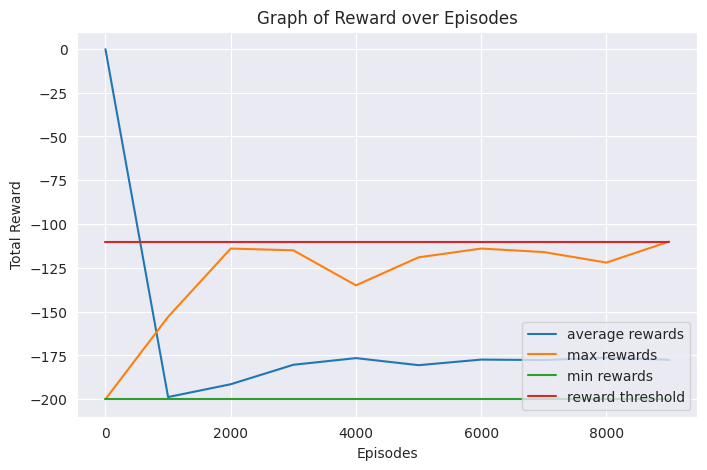

In [ ]:
m = 0
metrics_plot1(n=m)

For a measurement of the performance metrics, I have chosen to graph the reward achieved over each episode. I have also made a function to graph 2 histograms of actions over grid space and actions over step which are not displayed for this as the results were not recorded when I ran the test. However, they will be available for subsequent variants which we will explore below.

From the results above, we can see that there range of rewards achieved is quite varied and ideally, we would like to see the max, min and average rewards converge into a single value.

Now that we have verified that the functions and Q learning work, along with displaying the completion of the car reaching the end position and seeing the metrics, we can train different variations to see which is the best training method to achieve the objective.
<br> The first variation would be the same as the one we trained above. I have tried training with 20,000 episodes but I noticed that the terminal reward stage is reached before 10,000 episodes and so increasing the number of training episodes would not be beneficial and it would help to save time as well.

---
Variation name  | Learning Rate | Discount | Os_dim | Q_table | Epsilon_flag | Reward_Update
----------------|---------------|----------|--------|---------|--------------|----------------|
1 | 0.1 |0.95 |20 | Randomised Q table | True |0


In [ ]:
n = "1"

# Resetting the q_table
folder_name = f"./video/MountainCar-v0/{uuid.uuid4()}"
np.random.seed(888)
os_dim = 20
q_table = np.random.uniform(low=-2, high=0, size=([os_dim, os_dim] + [env.action_space.n]))

# Initialising the environment to run the test
# Running a diff environment instead of using wrapper RecordVideo to save time
env = gym.make("MountainCar-v0", render_mode = 'rgb_array')
observation, info = env.reset(seed=123)

aggr_ep_rewards, action_log = run_test(EPISODES=10000, env = env, epsilon_flag = True, n=n)
save_results(aggr_ep_rewards, action_log, n=n)

Streaming output truncated to the last 5000 lines.
Q table file is stored in /content/drive/My Drive/Saved Files/variation1-q_table.npy
Completed during episode run 7502. Total Reward during run: -127.0. No. of actions: 127.
Q table file is stored in /content/drive/My Drive/Saved Files/variation1-q_table.npy
Completed during episode run 7503. Total Reward during run: -127.0. No. of actions: 127.
Q table file is stored in /content/drive/My Drive/Saved Files/variation1-q_table.npy
Completed during episode run 7504. Total Reward during run: -127.0. No. of actions: 127.
Q table file is stored in /content/drive/My Drive/Saved Files/variation1-q_table.npy
Completed during episode run 7505. Total Reward during run: -127.0. No. of actions: 127.
Q table file is stored in /content/drive/My Drive/Saved Files/variation1-q_table.npy
Completed during episode run 7506. Total Reward during run: -127.0. No. of actions: 127.
Q table file is stored in /content/drive/My Drive/Saved Files/variation1-q_tabl

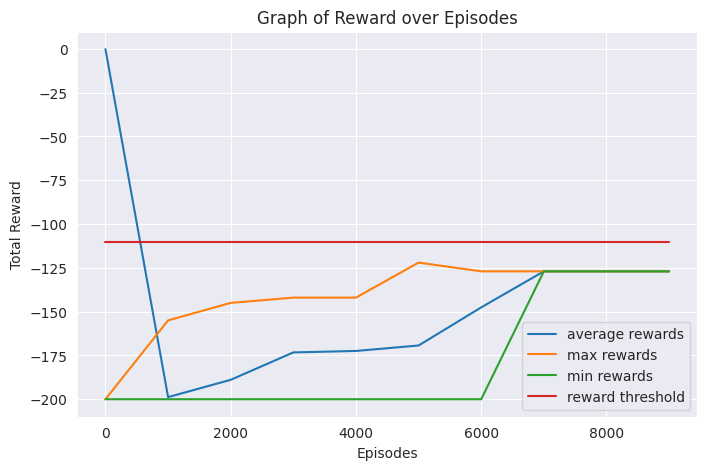

Terminal step : 127


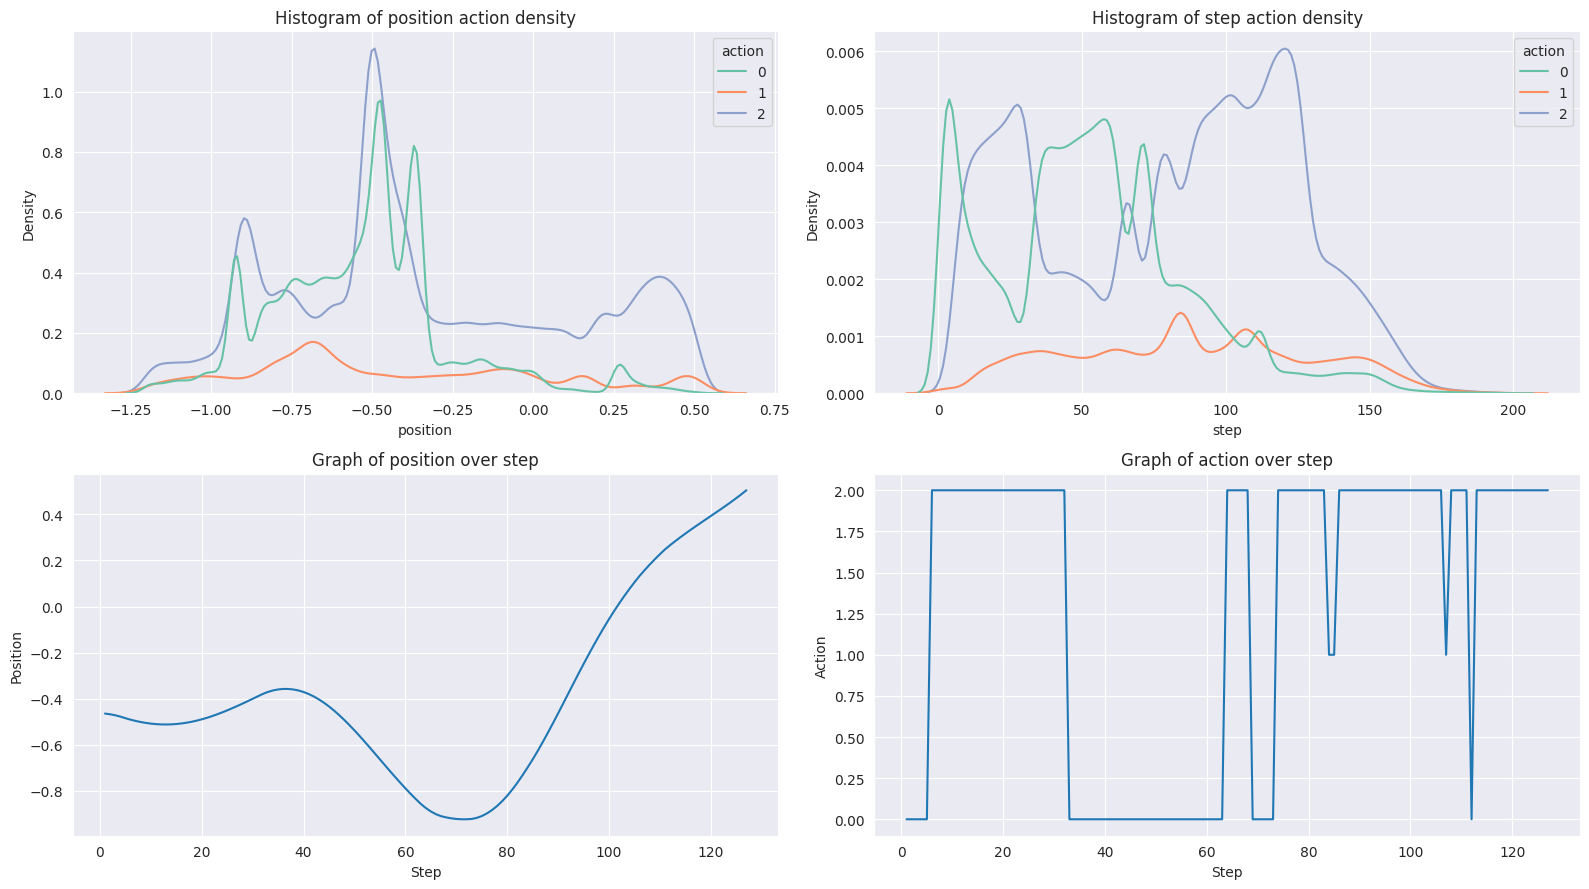

In [ ]:
m = 1
metrics_plot1(n=m)
metrics_plot2(n=m)

The graphs for the first test are plotted above.
<br>From the graph of Rewards over Episodes, we can see the behaviour is as per expected, with the average, max and min rewards converging to a single point. So the terminal point is -127, which doesn't meet the reward threshold but so far it's pretty good.
<br>The following 2 histograms are to see the distribution of actions over positions and steps for the episodes which have reached the goal step. It is interesting to see the distribution of actions across the positions and steps.
<br>The last 2 graphs are the position and actions taken over the steps for the last episode. Comparing the 2 charts side by side makes for some interesting observations.

---
We will run our second variation for testing, this time without the Epsilon, which means that there is no random exploration.

Variation name  | Learning Rate | Discount | Os_dim | Q_table | Epsilon_flag | Reward_Update
----------------|---------------|----------|--------|---------|--------------|----------------|
2 | 0.1 |0.95 |20 | Randomised Q table | False |0

In [ ]:
n = "2"

# Resetting the q_table
folder_name = f"./video/MountainCar-v0/{uuid.uuid4()}"
np.random.seed(888)
os_dim = 20
q_table = np.random.uniform(low=-2, high=0, size=([os_dim, os_dim] + [env.action_space.n]))

# Initialising the environment to run the test
# Running a diff environment instead of using wrapper RecordVideo to save time
env = gym.make("MountainCar-v0", render_mode = 'rgb_array')
observation, info = env.reset(seed=123)

aggr_ep_rewards, action_log = run_test(EPISODES=10000, env = env, epsilon_flag = False, n=n)
save_results(aggr_ep_rewards, action_log, n=n)

Streaming output truncated to the last 5000 lines.
Q table file is stored in /content/drive/My Drive/Saved Files/variation2-q_table.npy
Completed during episode run 7502. Total Reward during run: -127.0. No. of actions: 127.
Q table file is stored in /content/drive/My Drive/Saved Files/variation2-q_table.npy
Completed during episode run 7503. Total Reward during run: -127.0. No. of actions: 127.
Q table file is stored in /content/drive/My Drive/Saved Files/variation2-q_table.npy
Completed during episode run 7504. Total Reward during run: -127.0. No. of actions: 127.
Q table file is stored in /content/drive/My Drive/Saved Files/variation2-q_table.npy
Completed during episode run 7505. Total Reward during run: -127.0. No. of actions: 127.
Q table file is stored in /content/drive/My Drive/Saved Files/variation2-q_table.npy
Completed during episode run 7506. Total Reward during run: -127.0. No. of actions: 127.
Q table file is stored in /content/drive/My Drive/Saved Files/variation2-q_tabl

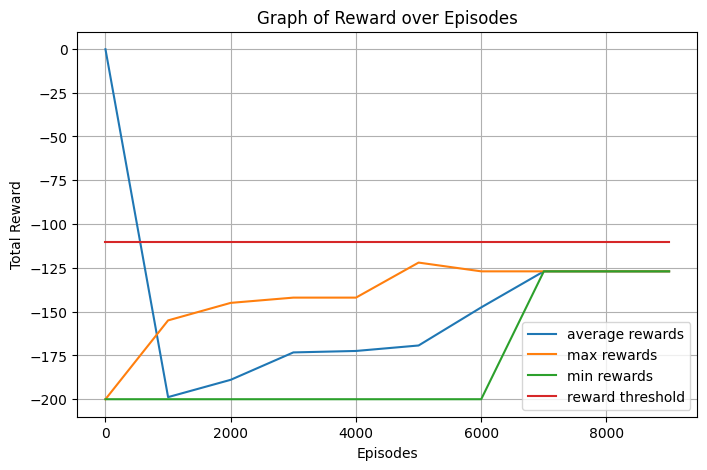

Terminal step : 127


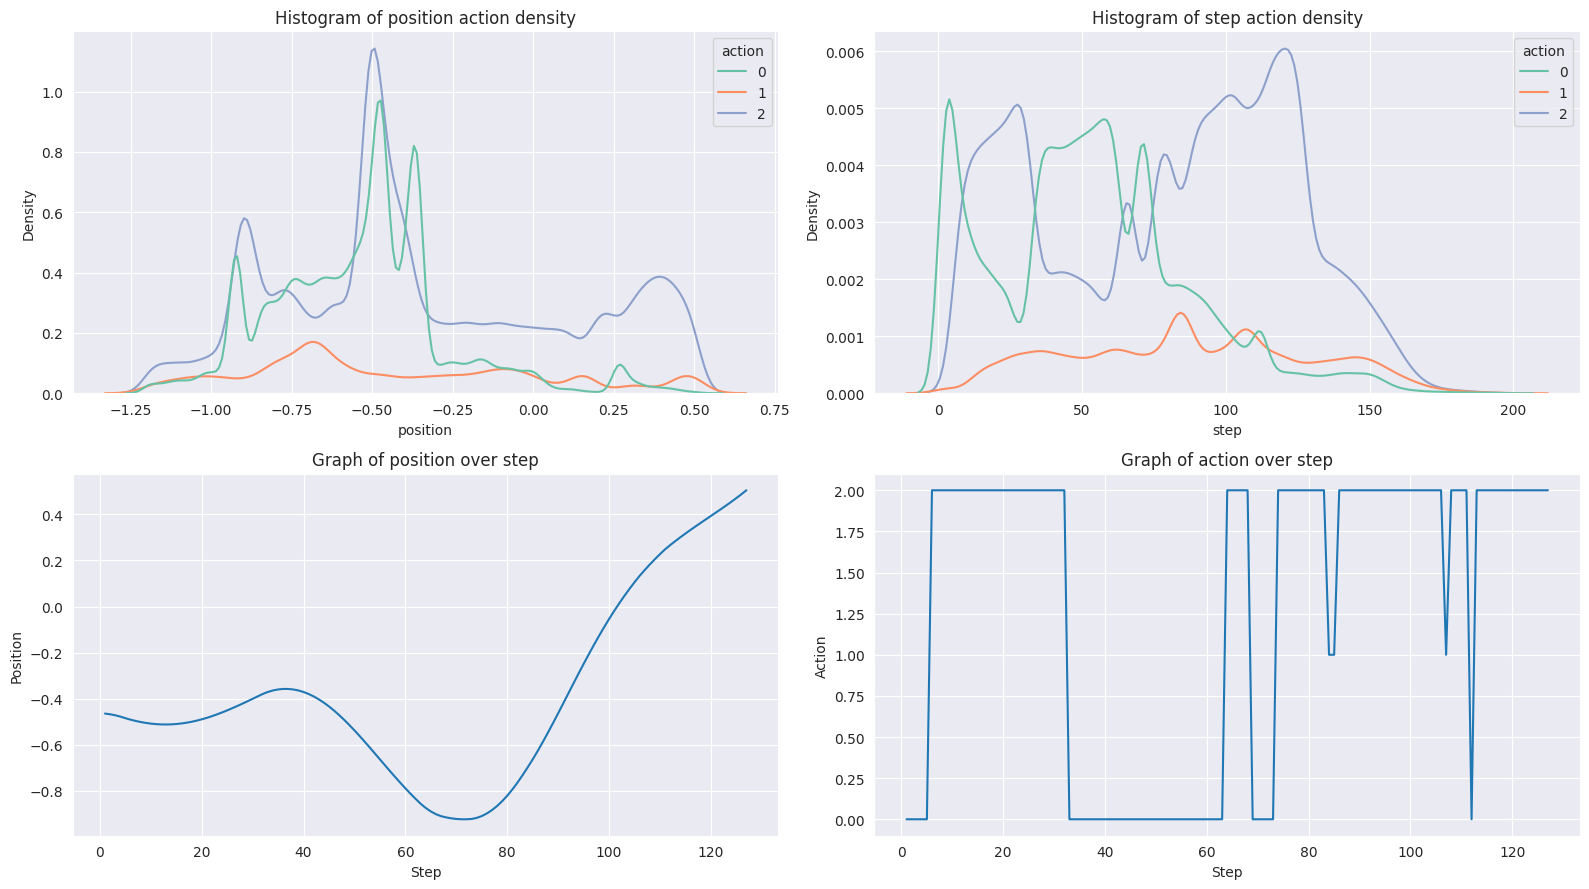

In [5]:
m = 2
metrics_plot1(n=m)
metrics_plot2(n=m)

Interestingly, the results without the random exploration are similar to the results of the agent with random exploration! The terminal reward is the same and the distributions of actions over position and steps are similar.

---
We will run our third variation for testing, this time increasing the size of the q-table. I will set the agent to perform random exploration as it is usually the case that exploration would help in performance.

Variation name  | Learning Rate | Discount | Os_dim | Q_table | Epsilon_flag | Reward_Update
----------------|---------------|----------|--------|---------|--------------|----------------|
3 | 0.1 |0.95 |40 | Randomised Q table | True |0

In [ ]:
n = "3"

# Resetting the q_table
folder_name = f"./video/MountainCar-v0/{uuid.uuid4()}"
np.random.seed(888)
os_dim = 40
q_table = np.random.uniform(low=-2, high=0, size=([os_dim, os_dim] + [env.action_space.n]))

# Initialising the environment to run the test
# Running a diff environment instead of using wrapper RecordVideo to save time
env = gym.make("MountainCar-v0", render_mode = 'rgb_array')
observation, info = env.reset(seed=123)

aggr_ep_rewards, action_log = run_test(EPISODES=10000, env = env, epsilon_flag = True, n=n)
save_results(aggr_ep_rewards, action_log, n=n)

Streaming output truncated to the last 5000 lines.
Q table file is stored in /content/drive/My Drive/Saved Files/variation3-q_table.npy
Completed during episode run 7502. Total Reward during run: -146.0. No. of actions: 146.
Q table file is stored in /content/drive/My Drive/Saved Files/variation3-q_table.npy
Completed during episode run 7503. Total Reward during run: -146.0. No. of actions: 146.
Q table file is stored in /content/drive/My Drive/Saved Files/variation3-q_table.npy
Completed during episode run 7504. Total Reward during run: -146.0. No. of actions: 146.
Q table file is stored in /content/drive/My Drive/Saved Files/variation3-q_table.npy
Completed during episode run 7505. Total Reward during run: -146.0. No. of actions: 146.
Q table file is stored in /content/drive/My Drive/Saved Files/variation3-q_table.npy
Completed during episode run 7506. Total Reward during run: -146.0. No. of actions: 146.
Q table file is stored in /content/drive/My Drive/Saved Files/variation3-q_tabl

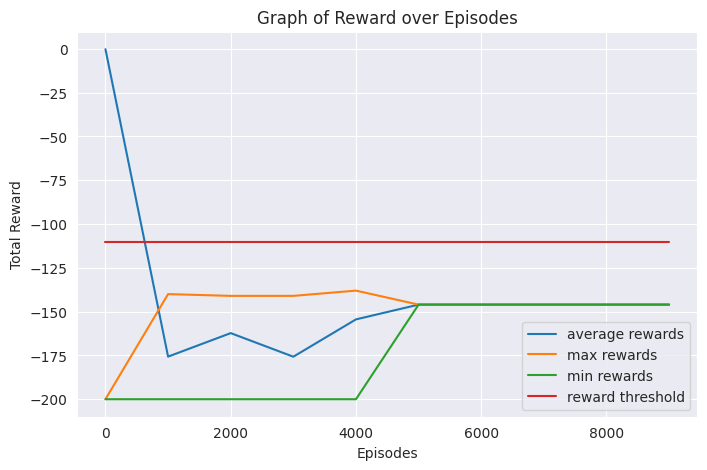

Terminal step : 146


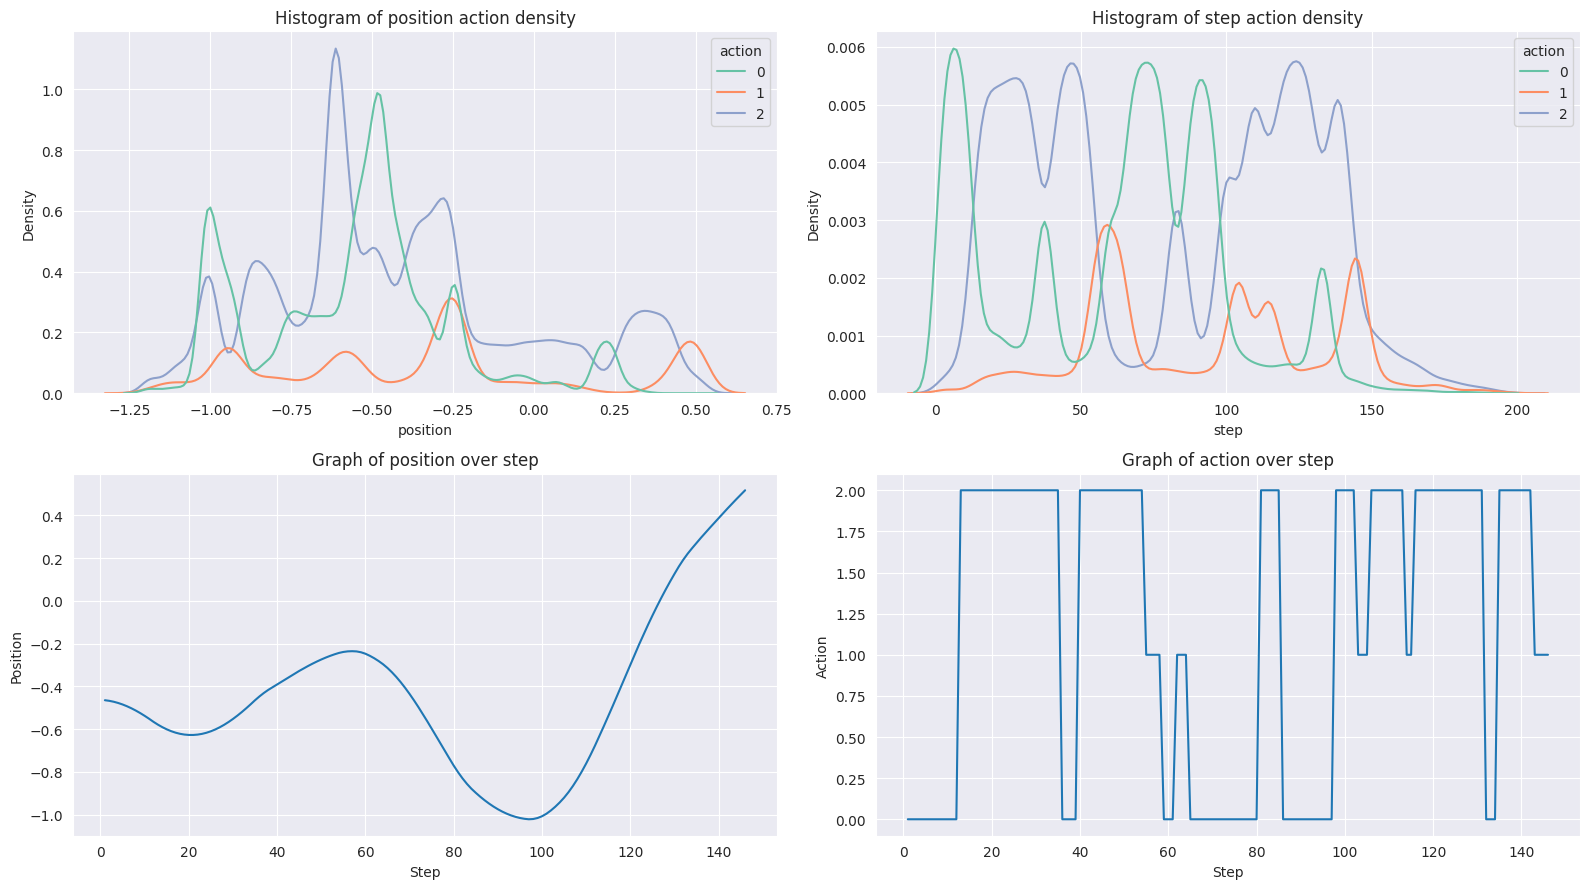

In [6]:
m = 3
metrics_plot1(n=m)
metrics_plot2(n=m)

Oh no, one would expect an increase in the size of the q-table would help with agent performance but this doesn't seem to be the case. The performance has dropped, with the terminal reward at -146 instead.

---
We will run our fourth variation for testing, this time setting the q-table values all to 0 instead of initialising with random numbers.

Variation name  | Learning Rate | Discount | Os_dim | Q_table | Epsilon_flag | Reward_Update
----------------|---------------|----------|--------|---------|--------------|----------------|
4 | 0.1 |0.95 |20 | Q table with 0s | True |0

In [22]:
n = "4"

# Resetting the q_table
folder_name = f"./video/MountainCar-v0/{uuid.uuid4()}"
np.random.seed(888)
os_dim = 20
q_table = np.zeros(shape=([os_dim, os_dim] + [env.action_space.n]))

# Initialising the environment to run the test
# Running a diff environment instead of using wrapper RecordVideo to save time
env = gym.make("MountainCar-v0", render_mode = 'rgb_array')
observation, info = env.reset(seed=123)

aggr_ep_rewards, action_log = run_test(EPISODES=10000, env = env, epsilon_flag = True, n=n)
save_results(aggr_ep_rewards, action_log, n=n)

Streaming output truncated to the last 5000 lines.
Q table file is stored in /content/drive/My Drive/Saved Files/variation4-q_table.npy
Completed during episode run 7502. Total Reward during run: -145.0. No. of actions: 145.
Q table file is stored in /content/drive/My Drive/Saved Files/variation4-q_table.npy
Completed during episode run 7503. Total Reward during run: -145.0. No. of actions: 145.
Q table file is stored in /content/drive/My Drive/Saved Files/variation4-q_table.npy
Completed during episode run 7504. Total Reward during run: -145.0. No. of actions: 145.
Q table file is stored in /content/drive/My Drive/Saved Files/variation4-q_table.npy
Completed during episode run 7505. Total Reward during run: -145.0. No. of actions: 145.
Q table file is stored in /content/drive/My Drive/Saved Files/variation4-q_table.npy
Completed during episode run 7506. Total Reward during run: -145.0. No. of actions: 145.
Q table file is stored in /content/drive/My Drive/Saved Files/variation4-q_tabl

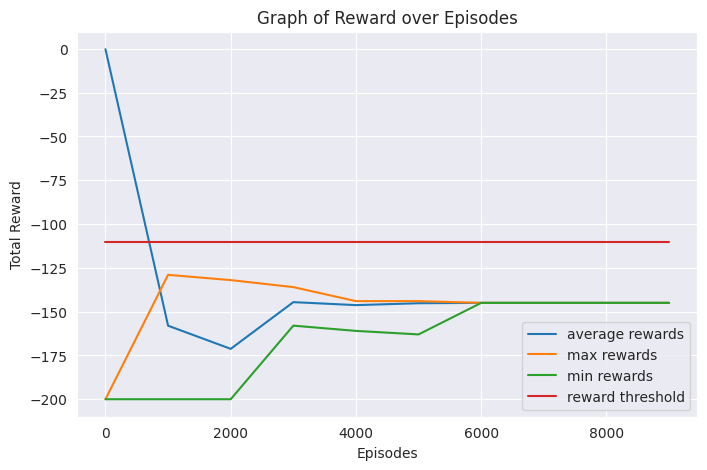

Terminal step : 145


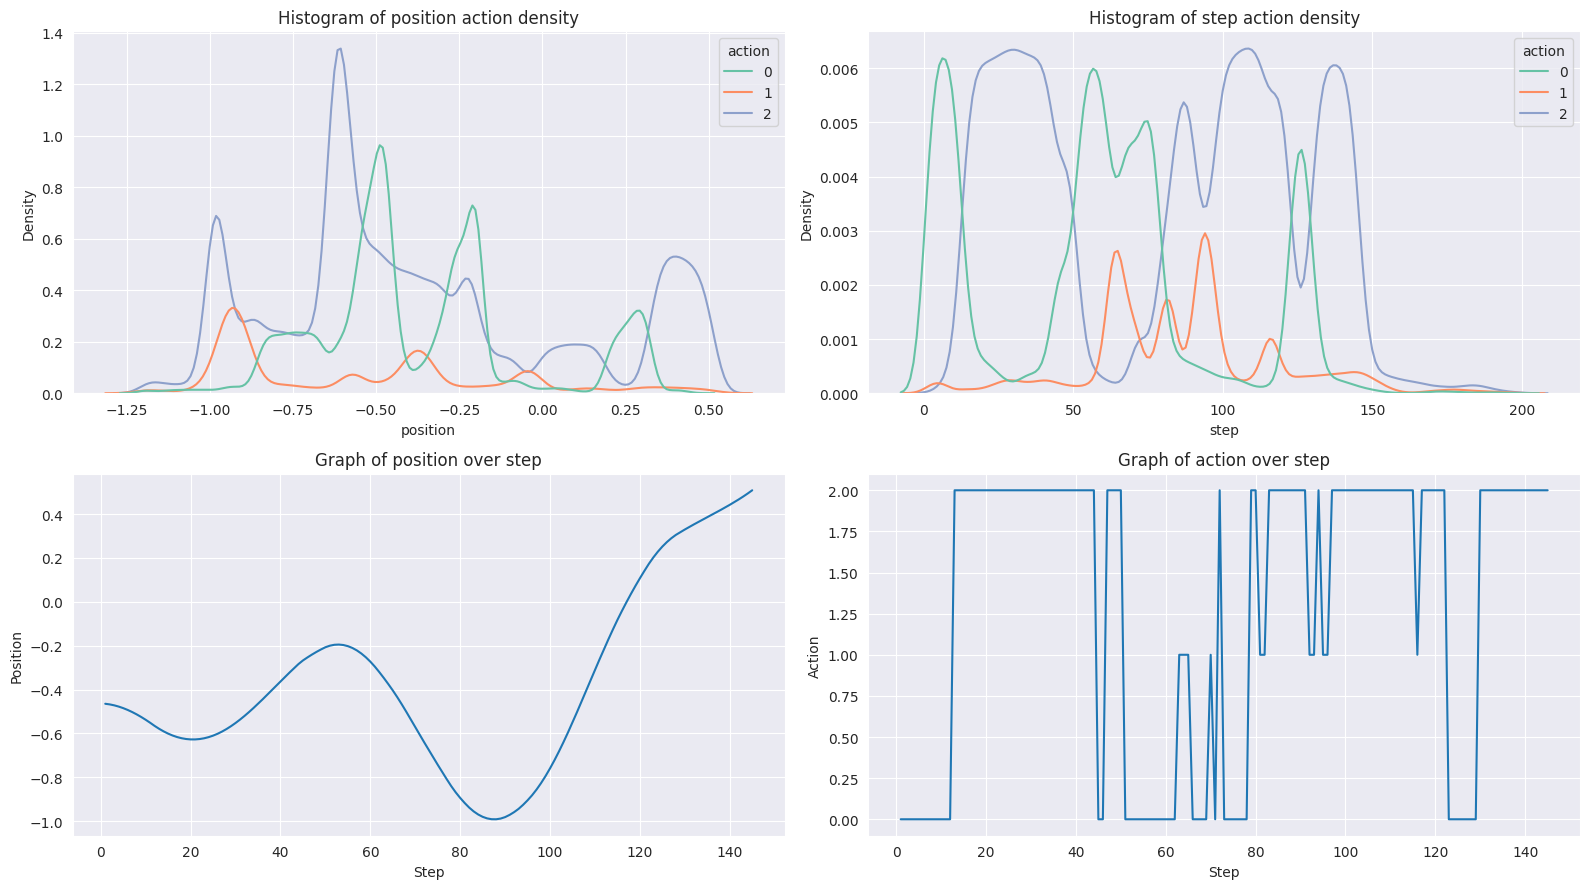

In [23]:
m = 4
metrics_plot1(n=m)
metrics_plot2(n=m)

Starting with a blank slate doesn't seem to have improved performance. While it did slightly better than the agent with a larger q-table, it achieved a performance of reward -145, it is still worst off compared to the first agent of -127.

---
We will run our fifth variation for testing, giving the agent a better reward upon reaching the goal position.

Variation name  | Learning Rate | Discount | Os_dim | Q_table | Epsilon_flag | Reward_Update
----------------|---------------|----------|--------|---------|--------------|----------------|
5| 0.1 |0.95 |20 | Randomised Q Table | True |5

In [25]:
n = "5"

# Resetting the q_table
folder_name = f"./video/MountainCar-v0/{uuid.uuid4()}"
np.random.seed(888)
os_dim = 20
q_table = np.zeros(shape=([os_dim, os_dim] + [env.action_space.n]))

# Resetting the q_table
folder_name = f"./video/MountainCar-v0/{uuid.uuid4()}"
np.random.seed(888)
aggr_ep_rewards, action_log = run_test(EPISODES=10000, env = env, epsilon_flag = True, n=n,reward_update=5)
save_results(aggr_ep_rewards, action_log, n=n)

Streaming output truncated to the last 5000 lines.
Q table file is stored in /content/drive/My Drive/Saved Files/variation5-q_table.npy
Completed during episode run 7502. Total Reward during run: -139.0. No. of actions: 139.
Q table file is stored in /content/drive/My Drive/Saved Files/variation5-q_table.npy
Completed during episode run 7503. Total Reward during run: -139.0. No. of actions: 139.
Q table file is stored in /content/drive/My Drive/Saved Files/variation5-q_table.npy
Completed during episode run 7504. Total Reward during run: -139.0. No. of actions: 139.
Q table file is stored in /content/drive/My Drive/Saved Files/variation5-q_table.npy
Completed during episode run 7505. Total Reward during run: -139.0. No. of actions: 139.
Q table file is stored in /content/drive/My Drive/Saved Files/variation5-q_table.npy
Completed during episode run 7506. Total Reward during run: -139.0. No. of actions: 139.
Q table file is stored in /content/drive/My Drive/Saved Files/variation5-q_tabl

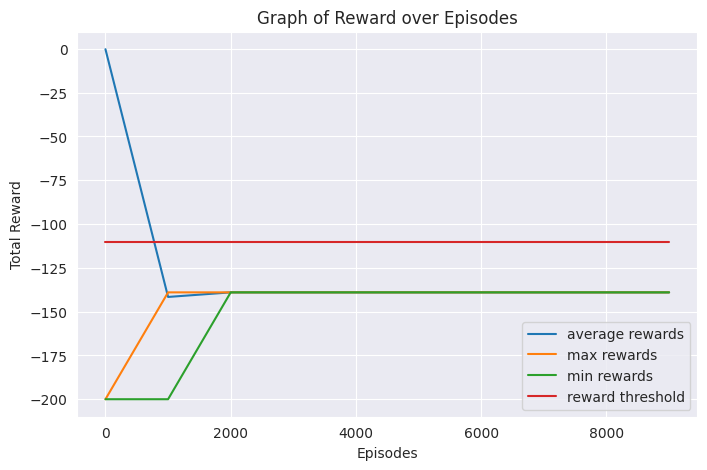

Terminal step : 139


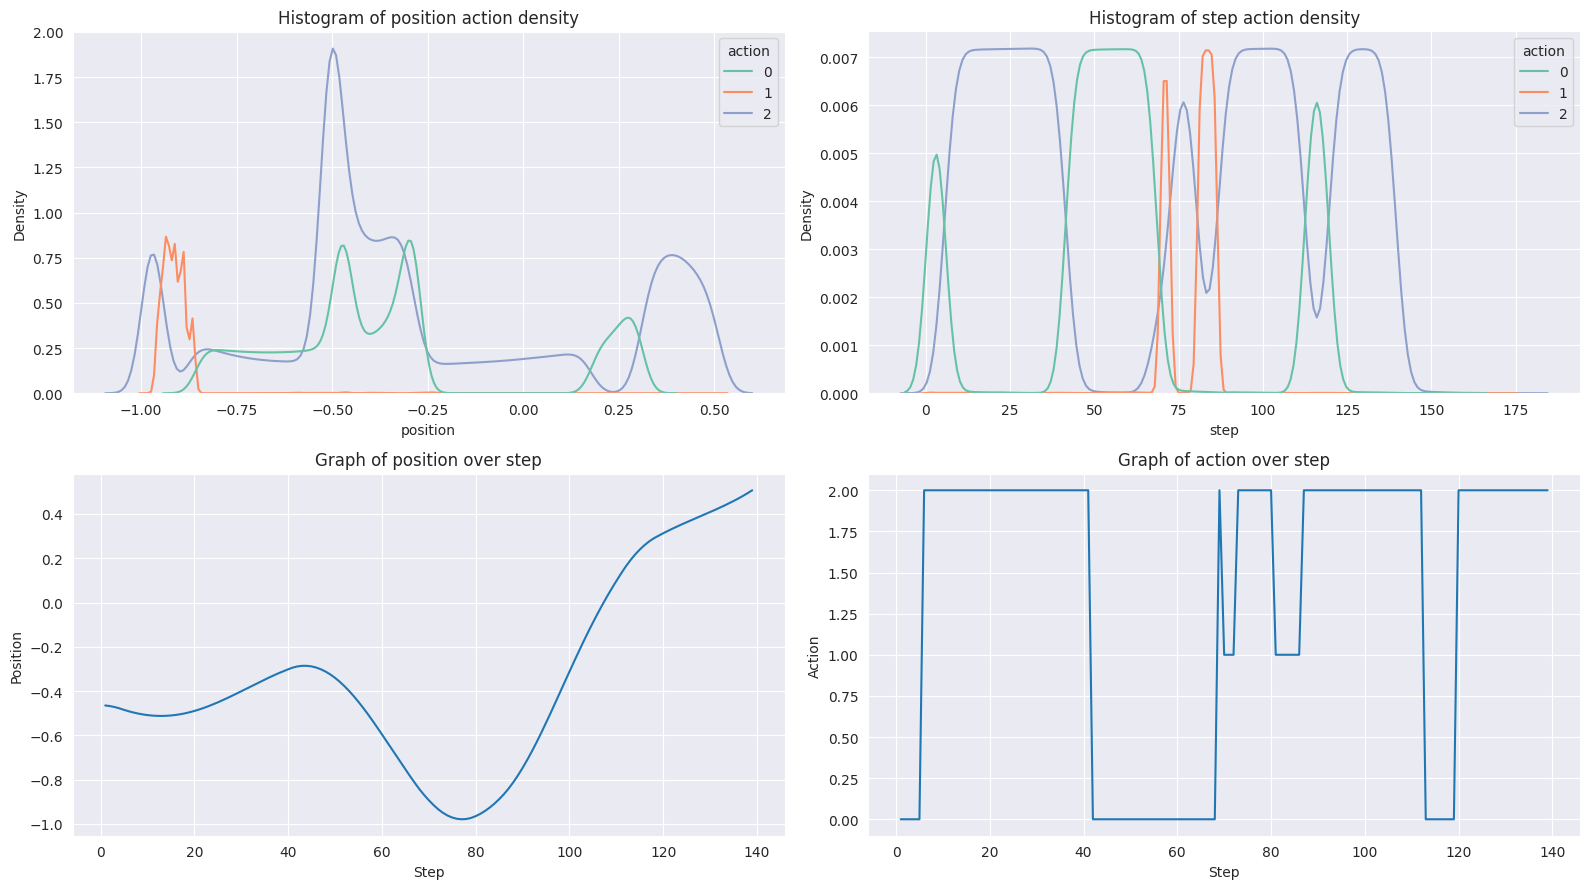

In [26]:
m = 5
metrics_plot1(n=m)
metrics_plot2(n=m)

There's no improvement in model despite the larger reward upon completion of goal step.


---

In the next iteration, we shall increase the learning rate to see if it makes a difference.

Variation name  | Learning Rate | Discount | Os_dim | Q_table | Epsilon_flag | Reward_Update
----------------|---------------|----------|--------|---------|--------------|----------------|
6| 0.5 |0.95 |20 | Randomised Q Table | True |0

In [27]:
n = "6"

# Resetting the q_table
folder_name = f"./video/MountainCar-v0/{uuid.uuid4()}"
np.random.seed(888)
os_dim = 20
q_table = np.random.uniform(low=-2, high=0, size=([os_dim, os_dim] + [env.action_space.n]))

# Initialising the environment to run the test
# Running a diff environment instead of using wrapper RecordVideo to save time
env = gym.make("MountainCar-v0", render_mode = 'rgb_array')
observation, info = env.reset(seed=123)

aggr_ep_rewards, action_log = run_test(EPISODES=10000, env = env, epsilon_flag = True, n=n, LEARNING_RATE=0.5)
save_results(aggr_ep_rewards, action_log, n=n)

Streaming output truncated to the last 5000 lines.
Q table file is stored in /content/drive/My Drive/Saved Files/variation6-q_table.npy
Completed during episode run 7502. Total Reward during run: -154.0. No. of actions: 154.
Q table file is stored in /content/drive/My Drive/Saved Files/variation6-q_table.npy
Completed during episode run 7503. Total Reward during run: -154.0. No. of actions: 154.
Q table file is stored in /content/drive/My Drive/Saved Files/variation6-q_table.npy
Completed during episode run 7504. Total Reward during run: -154.0. No. of actions: 154.
Q table file is stored in /content/drive/My Drive/Saved Files/variation6-q_table.npy
Completed during episode run 7505. Total Reward during run: -154.0. No. of actions: 154.
Q table file is stored in /content/drive/My Drive/Saved Files/variation6-q_table.npy
Completed during episode run 7506. Total Reward during run: -154.0. No. of actions: 154.
Q table file is stored in /content/drive/My Drive/Saved Files/variation6-q_tabl

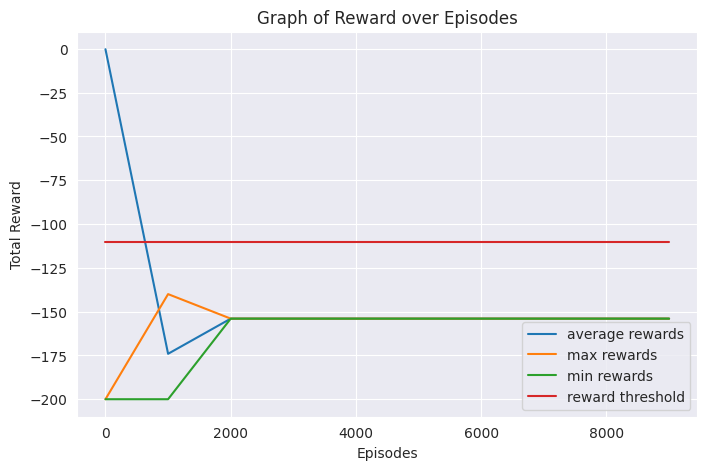

Terminal step : 154


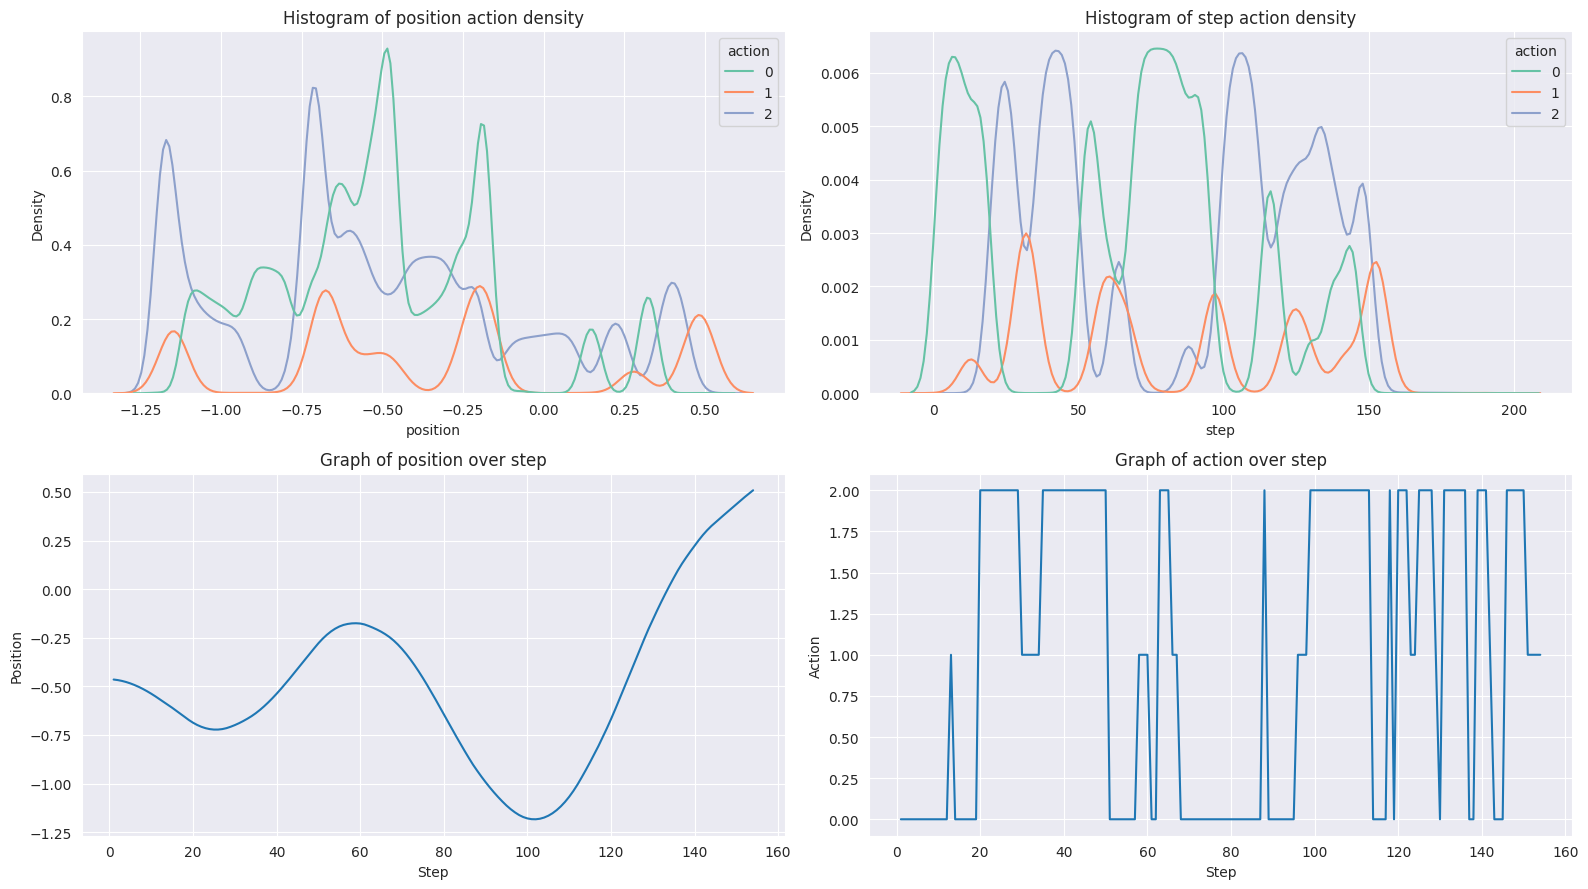

In [28]:
m = 6
metrics_plot1(n=m)
metrics_plot2(n=m)

Hmm no luck here despite increasing the learning rate by 400%.

---

How about we increase the learning rate by 150% instead?

Variation name  | Learning Rate | Discount | Os_dim | Q_table | Epsilon_flag | Reward_Update
----------------|---------------|----------|--------|---------|--------------|----------------|
7| 0.25 |0.95 |20 | Randomised Q Table | True |0

In [29]:
n = "7"

# Resetting the q_table
folder_name = f"./video/MountainCar-v0/{uuid.uuid4()}"
np.random.seed(888)
os_dim = 20
q_table = np.random.uniform(low=-2, high=0, size=([os_dim, os_dim] + [env.action_space.n]))

# Initialising the environment to run the test
# Running a diff environment instead of using wrapper RecordVideo to save time
env = gym.make("MountainCar-v0", render_mode = 'rgb_array')
observation, info = env.reset(seed=123)

aggr_ep_rewards, action_log = run_test(EPISODES=10000, env = env, epsilon_flag = True, n=n, LEARNING_RATE=0.25)
save_results(aggr_ep_rewards, action_log, n=n)

Streaming output truncated to the last 5000 lines.
Q table file is stored in /content/drive/My Drive/Saved Files/variation7-q_table.npy
Completed during episode run 7502. Total Reward during run: -149.0. No. of actions: 149.
Q table file is stored in /content/drive/My Drive/Saved Files/variation7-q_table.npy
Completed during episode run 7503. Total Reward during run: -149.0. No. of actions: 149.
Q table file is stored in /content/drive/My Drive/Saved Files/variation7-q_table.npy
Completed during episode run 7504. Total Reward during run: -149.0. No. of actions: 149.
Q table file is stored in /content/drive/My Drive/Saved Files/variation7-q_table.npy
Completed during episode run 7505. Total Reward during run: -149.0. No. of actions: 149.
Q table file is stored in /content/drive/My Drive/Saved Files/variation7-q_table.npy
Completed during episode run 7506. Total Reward during run: -149.0. No. of actions: 149.
Q table file is stored in /content/drive/My Drive/Saved Files/variation7-q_tabl

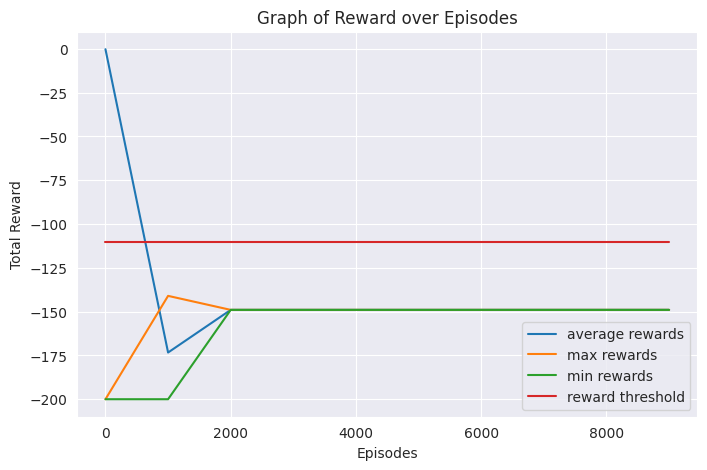

Terminal step : 149


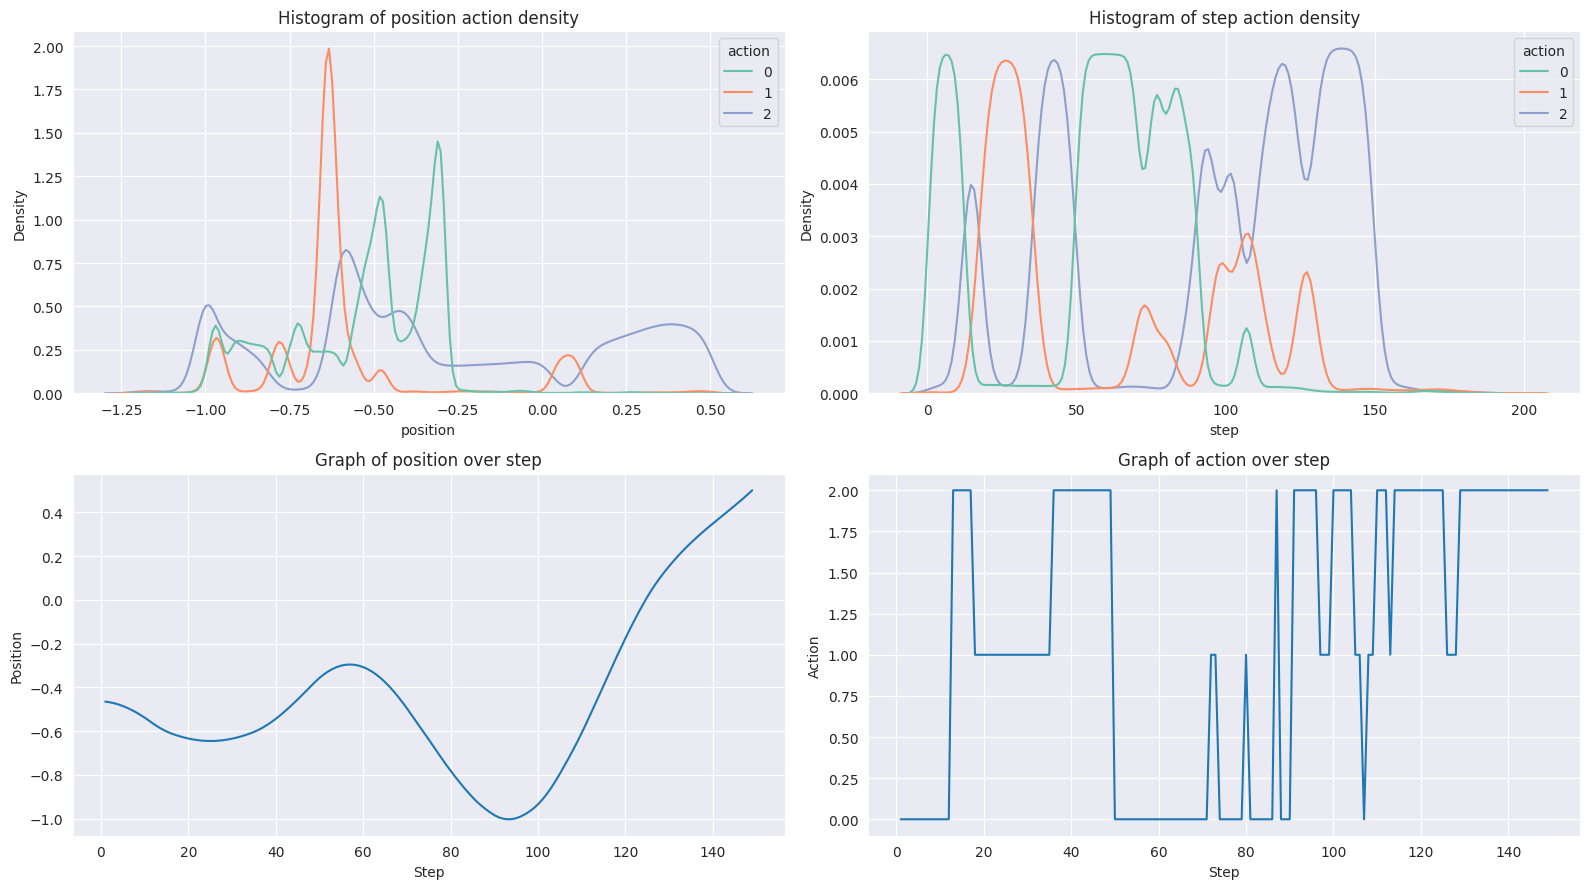

In [30]:
m = 7
metrics_plot1(n=m)
metrics_plot2(n=m)

Still no dice here.

So, what else can we try to improve further?

What we have tried so far, is Q-learning with Temporal difference. There is another type of Q-learning but with Monte Carlo instead. Temporal difference is said to perform better than Monte Carlo, hence I started with it instead. But we can still run Monte Carlo, to see if it can defy expectations and perform better instead. Let's define the Monte Carlo codes below and start to run the test. For this, we will be using the Every Step Monte Carlo.

<br> Just a caveat before we start, I'm not an expert in this so I may be incorrect in the implementation of the Every Step Monte Carlo.

In [43]:
# Defining the code for Every Step Monte Carlo

def run_test_mtc(n
             ,env = env
             ,EPISODES = 4
             ,os_dim = 20
             ,q_table = q_table
             ,epsilon_flag = True
             ,reward_update = 0):

  """
  Q-Learning settings
  EPISODES = 100
  os_dim = 20
  reward_update = 0
  """

  # Creating the observation bucketing
  DISCRETE_OS_SIZE = [os_dim, os_dim]
  discrete_os_win_size = (env.observation_space.high - env.observation_space.low)/DISCRETE_OS_SIZE

  # Exploration settings
  epsilon_flag = True
  epsilon = 1  # not a constant, going to be decayed
  START_EPSILON_DECAYING = 1
  END_EPSILON_DECAYING = EPISODES//2
  epsilon_decay_value = epsilon/(END_EPSILON_DECAYING - START_EPSILON_DECAYING)

  # Computing Metrics
  episode_division = 1000
  ep_rewards = []
  aggr_ep_rewards = {'ep': [], 'avg': [], 'max': [], 'min': []}
  action_log = {'position': [], 'velocity': [], 'action': [], 'step': [], 'terminal_step': []}

  def get_discrete_state(state):
      discrete_state = (state - env.observation_space.low)/discrete_os_win_size
      return tuple(discrete_state.astype(np.int64))


  for episode in range(EPISODES):
      obs, _ = env.reset(seed=123)
      discrete_state = get_discrete_state(obs)
      terminated = False
      truncated = False
      r = 0
      a = 0

      if not episode % episode_division:
        print(f"Starting to run episode : {episode}")

      while not terminated and not truncated:

          if (epsilon_flag == True and np.random.random()> epsilon) or epsilon_flag == False:
              # Get action from Q table
              action = np.argmax(q_table[discrete_state])
          else:
              # Get random action
              action = np.random.randint(0, env.action_space.n)

          new_state, reward, terminated, truncated, info = env.step(action)
          r += reward
          a += 1

          # Logging the stats of each step
          action_log['position'].append(new_state[0])
          action_log['velocity'].append(new_state[1])
          action_log['action'].append(action)
          action_log['step'].append(a)

          new_discrete_state = get_discrete_state(new_state)

          # If simulation did not end yet after last step - update Q table
          if not terminated and not truncated:

            # Maximum possible Q value in next step (for new state)
            max_future_q = np.max(q_table[new_discrete_state])

            # Current Q value (for current state and performed action)
            current_q = q_table[discrete_state + (action,)]

            # And here's our equation for a new Q value for current state and action with Every Step Monte Carlo
            new_q = current_q + (max_future_q-current_q)/a

            # Update Q table with new Q value
            q_table[discrete_state + (action,)] = new_q

          elif terminated or truncated:
            # Delete records if goal is not achieved. To record only episodes which have accomplished the goal
            if new_state[0] < env.unwrapped.goal_position:
              action_log['position'] = action_log['position'][:len(action_log['position']) - 200]
              action_log['velocity'] = action_log['velocity'][:len(action_log['velocity']) - 200]
              action_log['action'] = action_log['action'][:len(action_log['action']) - 200]
              action_log['step'] = action_log['step'][:len(action_log['step']) - 200]

          # Simulation ended (for any reason) - if goal position is achieved - update Q value with reward directly
            elif new_state[0] >= env.unwrapped.goal_position:
              q_table[discrete_state + (action,)] = reward_update
              # Saving the results of the q table for subsequent display
              fp_q_table = "/content/drive/My Drive/Saved Files/" + "variation" + str(n) + "-q_table" + ".npy"
              np.save(fp_q_table, q_table)
              action_log['terminal_step'].append(a)
              print(f"Q table file is stored in {fp_q_table}")
              print(f"Completed during episode run {episode}. Total Reward during run: {r}. No. of actions: {a}.")

          discrete_state = new_discrete_state

        # Decaying is being done every episode if episode number is within decaying range
          if END_EPSILON_DECAYING >= episode >= START_EPSILON_DECAYING:
            epsilon -= epsilon_decay_value

      ep_rewards.append(r)
      if not episode % episode_division:
          average_reward = sum(ep_rewards[-episode_division:])/episode_division
          aggr_ep_rewards['ep'].append(episode)
          aggr_ep_rewards['avg'].append(average_reward)
          aggr_ep_rewards['max'].append(max(ep_rewards[-episode_division:]))
          aggr_ep_rewards['min'].append(min(ep_rewards[-episode_division:]))
          #print(f'Episode: {episode:>5d}, average reward: {average_reward:>4.1f}, current epsilon: {epsilon:>1.2f}')

      env.close()

  print(f"Video file is stored in {folder_name}")
  return aggr_ep_rewards, action_log

Now that we have defined the Every Step Monte Carlo Agent, we can start to train the agent. Since it is Monte Carlo, it doesn't utilise incremental learning rates and instead takes an incremental mean of the q_table. As such, it is likely that more learning episodes are required and so, here we increase the number of training episodes

Variation name  | Learning Rate | Discount | Os_dim | Q_table | Epsilon_flag | Reward_Update
----------------|---------------|----------|--------|---------|--------------|----------------|
8| 0.0 |0.0 |20 | Randomised Q Table | True |0

In [47]:
n = "8"

# Resetting the q_table
folder_name = f"./video/MountainCar-v0/{uuid.uuid4()}"
np.random.seed(888)
os_dim = 20
q_table = np.random.uniform(low=-2, high=0, size=([os_dim, os_dim] + [env.action_space.n]))

# Initialising the environment to run the test
# Running a diff environment instead of using wrapper RecordVideo to save time
env = gym.make("MountainCar-v0", render_mode = 'rgb_array')
observation, info = env.reset(seed=123)

aggr_ep_rewards, action_log = run_test_mtc(EPISODES=100000, env = env, epsilon_flag = True, n=n)
save_results(aggr_ep_rewards, action_log, n=n)

Starting to run episode : 0
Starting to run episode : 1000
Starting to run episode : 2000
Starting to run episode : 3000
Starting to run episode : 4000
Starting to run episode : 5000
Starting to run episode : 6000
Starting to run episode : 7000
Starting to run episode : 8000
Starting to run episode : 9000
Starting to run episode : 10000
Starting to run episode : 11000
Starting to run episode : 12000
Starting to run episode : 13000
Starting to run episode : 14000
Starting to run episode : 15000
Starting to run episode : 16000
Starting to run episode : 17000
Starting to run episode : 18000
Starting to run episode : 19000
Starting to run episode : 20000
Starting to run episode : 21000
Starting to run episode : 22000
Starting to run episode : 23000
Starting to run episode : 24000
Starting to run episode : 25000
Starting to run episode : 26000
Starting to run episode : 27000
Starting to run episode : 28000
Starting to run episode : 29000
Starting to run episode : 30000
Starting to run episo

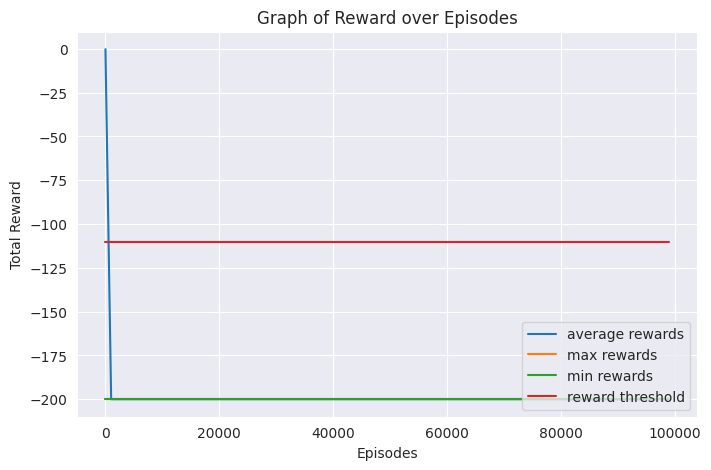

In [49]:
m = 8
metrics_plot1(n=m)
#metrics_plot2(n=m)

Hmm... no results. What if we set it to not have random exploration, would the results be better?

Variation name  | Learning Rate | Discount | Os_dim | Q_table | Epsilon_flag | Reward_Update
----------------|---------------|----------|--------|---------|--------------|----------------|
9| 0.0 |0.0 |20 | Randomised Q Table | False |0

In [50]:
n = "9"

# Resetting the q_table
folder_name = f"./video/MountainCar-v0/{uuid.uuid4()}"
np.random.seed(888)
os_dim = 20
q_table = np.random.uniform(low=-2, high=0, size=([os_dim, os_dim] + [env.action_space.n]))

# Initialising the environment to run the test
# Running a diff environment instead of using wrapper RecordVideo to save time
env = gym.make("MountainCar-v0", render_mode = 'rgb_array')
observation, info = env.reset(seed=123)

aggr_ep_rewards, action_log = run_test_mtc(EPISODES=100000, env = env, epsilon_flag = False, n=n)
save_results(aggr_ep_rewards, action_log, n=n)

Starting to run episode : 0
Starting to run episode : 1000
Starting to run episode : 2000
Starting to run episode : 3000
Starting to run episode : 4000
Starting to run episode : 5000
Starting to run episode : 6000
Starting to run episode : 7000
Starting to run episode : 8000
Starting to run episode : 9000
Starting to run episode : 10000
Starting to run episode : 11000
Starting to run episode : 12000
Starting to run episode : 13000
Starting to run episode : 14000
Starting to run episode : 15000
Starting to run episode : 16000
Starting to run episode : 17000
Starting to run episode : 18000
Starting to run episode : 19000
Starting to run episode : 20000
Starting to run episode : 21000
Starting to run episode : 22000
Starting to run episode : 23000
Starting to run episode : 24000
Starting to run episode : 25000
Starting to run episode : 26000
Starting to run episode : 27000
Starting to run episode : 28000
Starting to run episode : 29000
Starting to run episode : 30000
Starting to run episo

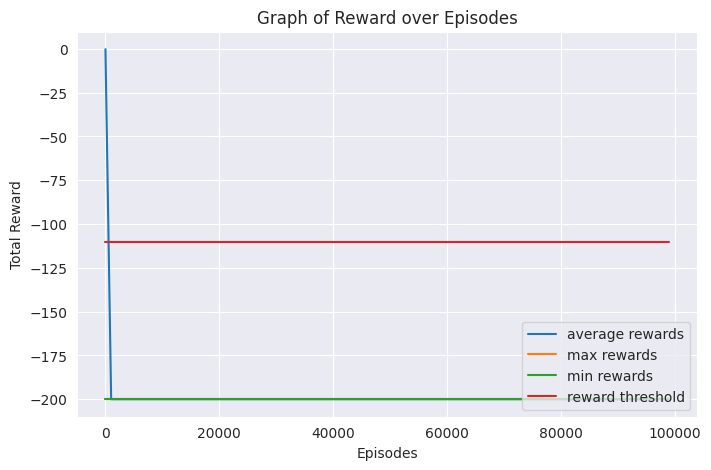

In [51]:
m = 9
metrics_plot1(n=m)
#metrics_plot2(n=m)

Oh no, after training for so long, it seems that training the Every Step Monte Carlo Agent for both exploration and non-exploration doesn't seem to be working well, and it doesn't seem to make much progress in training.


**Conclusion**
---
So far, we have tried various Q-Learning to train the agent to reach the goal position. We have tried the below variations, with varied successes and failures.

Variation name  | Learning Rate | Discount | Os_dim | Q_table | Epsilon_flag | Reward_Update | Terminal Step
----------------|---------------|----------|--------|---------|--------------|----------------|---------------|
1| 0.1 |0.95 |20 | Randomised Q table | True |0 |127
2| 0.1 |0.95 |20 | Randomised Q table | False |0 |127
3| 0.1 |0.95 |40 | Randomised Q table | True |0 |146
4| 0.1 |0.95 |20 | Q table with 0s | True |0 |145
5| 0.1 |0.95 |20 | Randomised Q Table | True |5 |139
6| 0.5 |0.95 |20 | Randomised Q Table | True |0 |154
7| 0.25 |0.95 |20 | Randomised Q Table | True |0 |149
8| 0.0 |0.0 |20 | Randomised Q Table | True |0 |200
9| 0.0 |0.00 |20 | Randomised Q Table | False |0 |200

Ultimately the best performing one seems to be variants 1 and 2, and even so, they did not meet the reward threshold criteria of 110. Apart from Q-learning, there are other forms of Reinforcement Learning which are not explored here which could be tried to conquer the MountainCar as well, such as SARSA.